In [1]:
using CSV, DataFrames, Statistics
using PyPlot # plotting library
using PyCall
using Printf
using FStrings
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"

# check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-pastel")

# change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

#make jupyter notebook print more dataframe columns
ENV["COLUMNS"]=160
hand = "2v2"

print("Ready to go!")

Ready to go!

-----

# Reading in the Data
Now reading in the metrics data for 2v2.

In [2]:
df_2v2 = CSV.read("results/2v2_metrics.csv", DataFrame, copycols=true)
first(df_2v2, 10)

,trial,arc_len,area_btwn,max_a_loc,max_a_reg,max_err,mvt_eff,r_fd,t_fd
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,sub1_2v2_a_n_1,0.915118,0.0210593,0.9,0.00490139,0.0276,0.402884,4.903,0.0277119
2,sub1_2v2_a_n_2,0.7148,0.0241181,0.9,0.00206908,0.0188,0.508725,8.6598,0.0194225
3,sub1_2v2_a_n_3,1.28018,0.0384869,0.9,0.00662867,0.0194,0.276161,6.2054,0.0429625
4,sub2_2v2_a_n_1,0.67969,0.0111813,0.91,0.00220399,0.0153,0.460697,5.7871,0.0210955
5,sub2_2v2_a_n_2,1.16322,0.0402499,0.91,0.00261126,0.0329,0.199724,6.382,0.146714
6,sub2_2v2_a_n_3,1.03924,0.0401208,0.9,0.00178644,0.0224,0.247849,6.2749,0.092246
7,sub1_2v2_b_n_1,1.17382,0.0550738,0.89,0.0141378,0.0761554,0.346836,9.9023,0.0761564
8,sub1_2v2_b_n_2,0.830463,0.0309432,0.89,0.00550953,0.0354968,0.490235,5.0048,0.0355077
9,sub1_2v2_b_n_3,0.976513,0.049745,0.75,0.00749884,0.0833679,0.424228,8.6378,0.0833772


## Asterisk Plot

![Avg Asterisk](./pics/avgd_2v2_2subs_n.jpg)

-----

# Histograms of Metrics
Now I will produce histogram plots of the metrics to see what kind of a distribution we get for all the trials.
Shamelessly taken from my previous datascience course at: [link](https://github.com/SimonEnsemble/data_science_course)

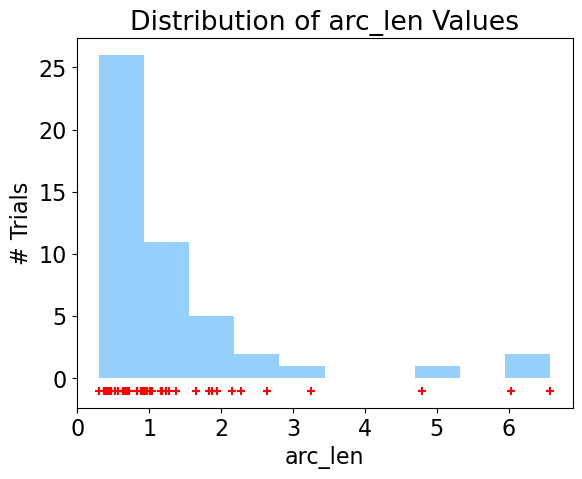

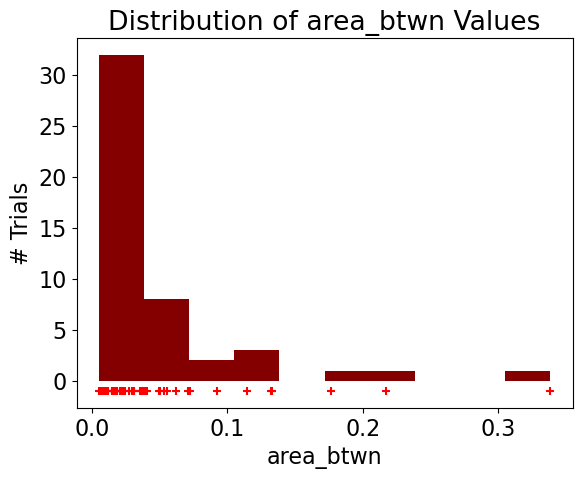

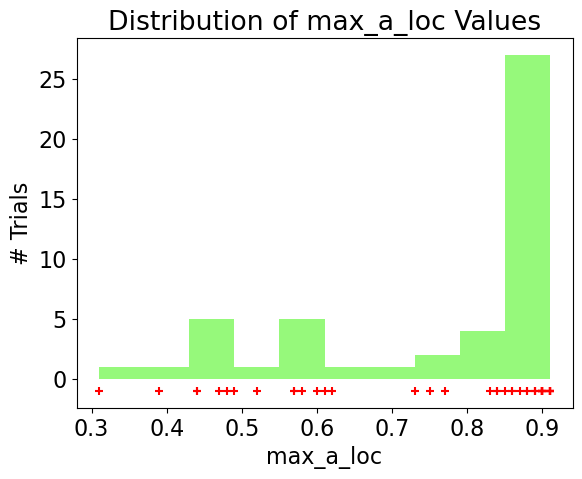

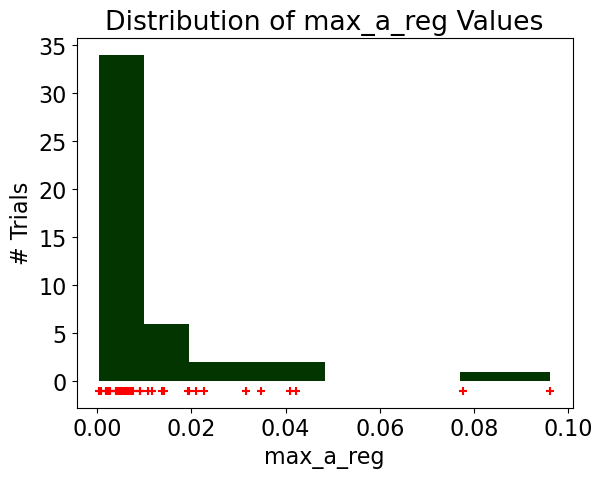

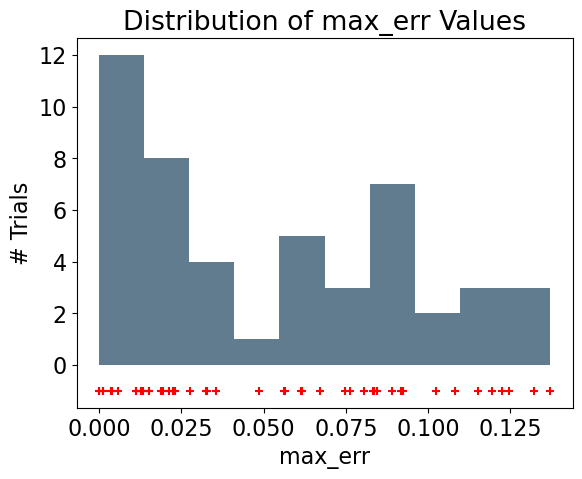

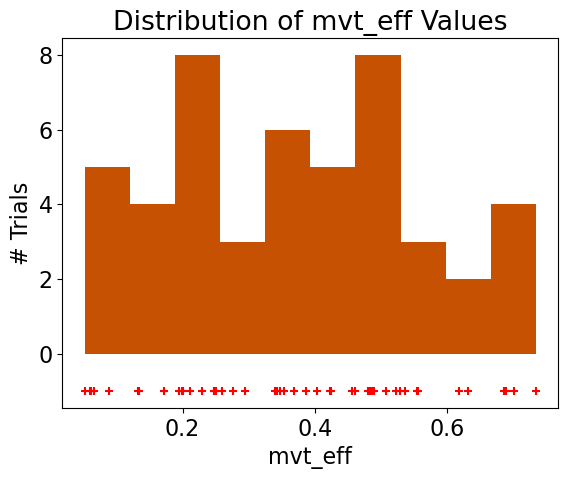

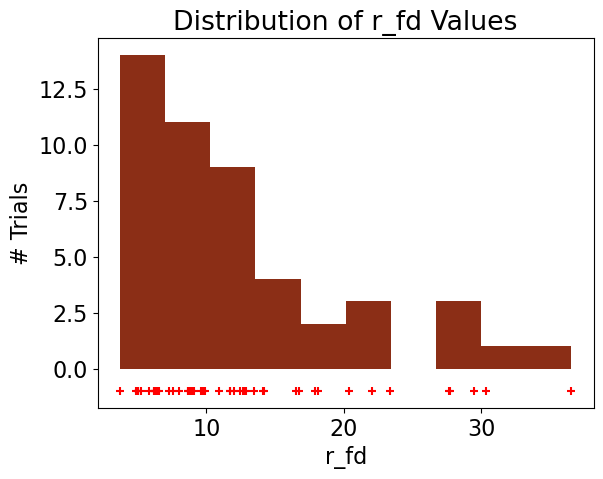

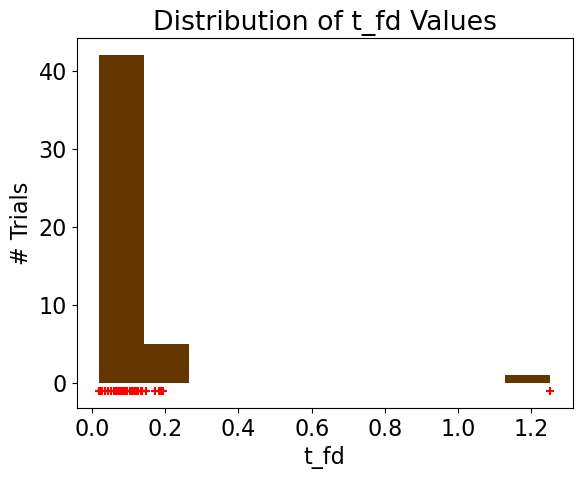

In [3]:
metrics = [:arc_len, :area_btwn, :max_a_loc, :max_a_reg, :max_err, :mvt_eff, :r_fd, :t_fd]

plot_colors = ["xkcd:light blue", "xkcd:dark red", "xkcd:light green", "xkcd:dark green",
               "xkcd:blue grey", "xkcd:dark orange", "xkcd:red brown", "xkcd:brown"]

i = 1
for m in metrics
    figure()
    hist(df_2v2[:, m], color=plot_colors[i]) #, normed=true)
    scatter(df_2v2[:, m], [-1 for i = 1:nrow(df_2v2)], marker="+", color="r")
    xlabel(f"{m}")
    ylabel("# Trials")
    title(f"Distribution of {m} Values")
    i = i + 1
end

### Observations of Histogram Plots
Based on what I see, here are the observations per metric (in order of appearance top to down):
* **arc length**: mostly concentrated at low arc lengths
* **max area region location**: mostly, the region of max error area is most commonly found at the end
* **max area region**: at the locations of max error area, the area of error (aka the area between the path and the target line) is still relatively low
* **max error**: values are distributed
* **movement efficiency**: values are distributed
* **rotational frechet distance**: aka max rotation error. Mostly low, but larger distribution at the low end
* translational frechet distance: all values are very low

----

# Metric Values by direction
Plot all metric values in bar charts by direction

In [4]:
subjects = ["sub1", "sub2"]
translations = ["a", "b", "c", "d", "e", "f", "g", "h"]
rotations = ["n"]

function get_trial_vals(df::DataFrame, metric::Symbol, translation::String)
    hand = "2v2"
    subjects = ["sub1", "sub2"]
    numbers = ["1", "2", "3"] #, "4", "5"]
    
    values = []
    names = []
    
    for s in subjects
        for n in numbers
            trial_name = f"{s}_{hand}_{translation}_n_{n}"
            plot_name = f"{s}_{n}"
            row = df[df[!, :trial] .== trial_name, :]
            val = row[!, metric][1]
            
            push!(values, val)
            push!(names, plot_name)
        end
    end
    
    return values, names
end


function plt_metric_and_directions(m::Symbol, c::String="nothing")
    
    for t in translations
        figure()
        plt_title = f"{hand}: {m} - {t}_n"
        values, names = get_trial_vals(df_2v2, m, t)

        if c == "nothing"
            bar(names, values)
        else
            bar(names, values, color=c)
        end
        xticks(rotation=-30, ha="left")
        title(plt_title)
    end
end

print("Functions are ready!")

Functions are ready!

### Arc Length


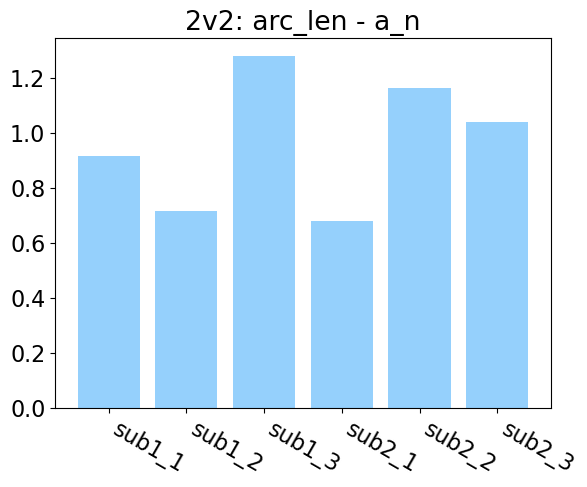

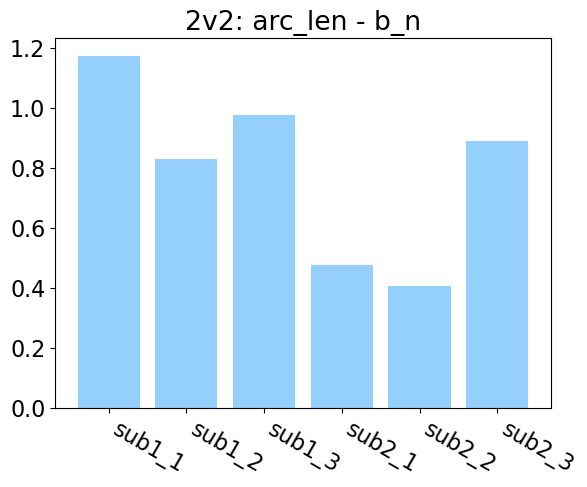

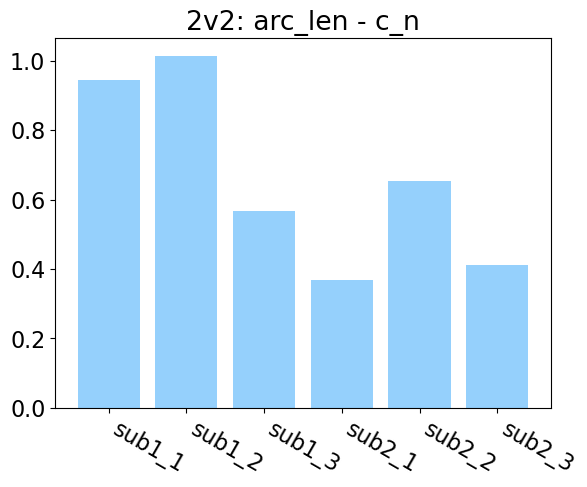

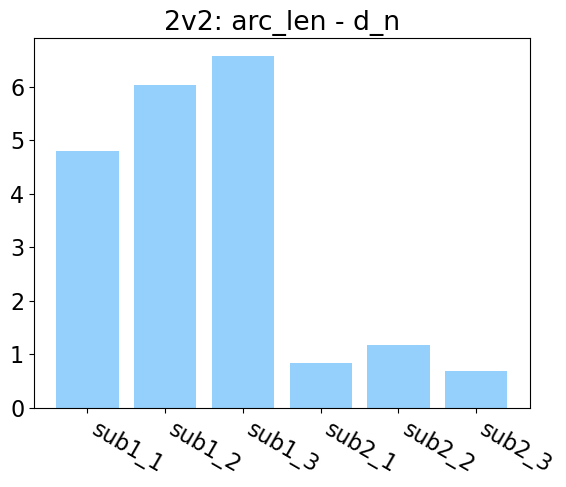

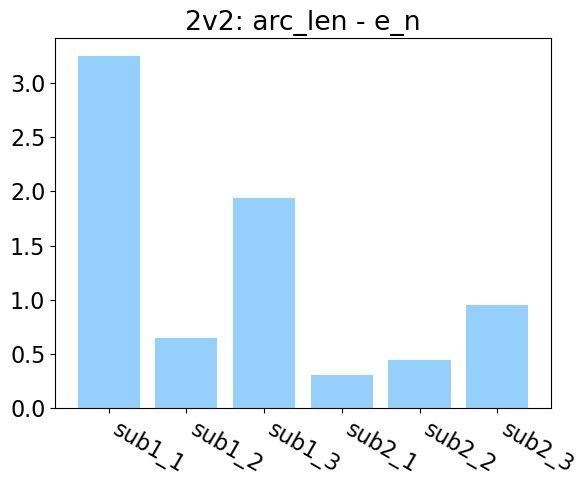

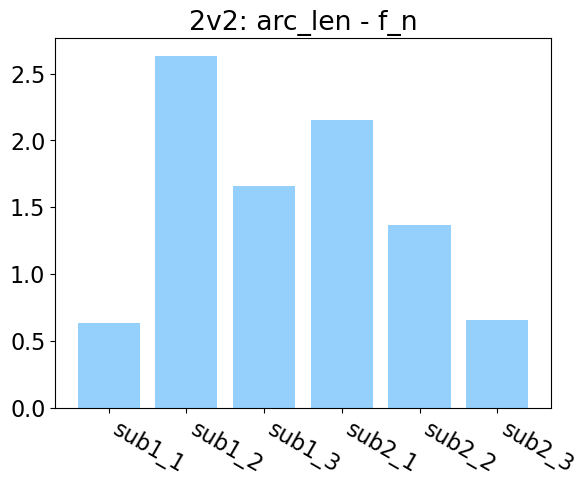

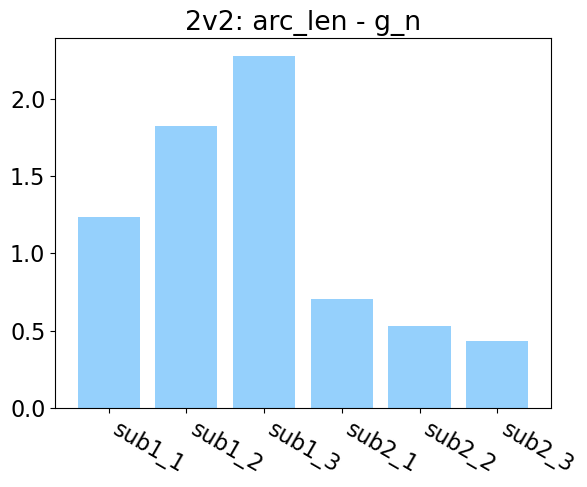

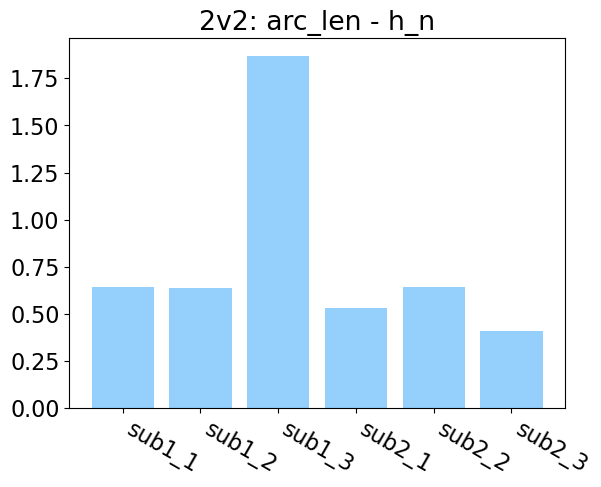

In [5]:
plt_metric_and_directions(:arc_len, "xkcd:light blue")

### area_btwn

metrics = [:arc_len, :area_btwn, :max_a_loc, :max_a_reg, :max_err, :mvt_eff, :r_fd, :t_fd]

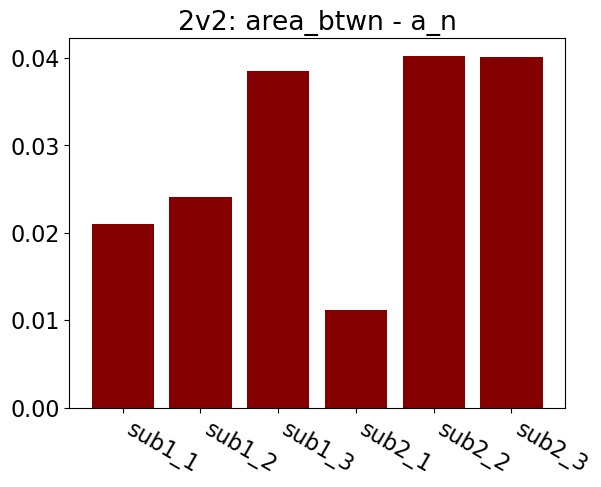

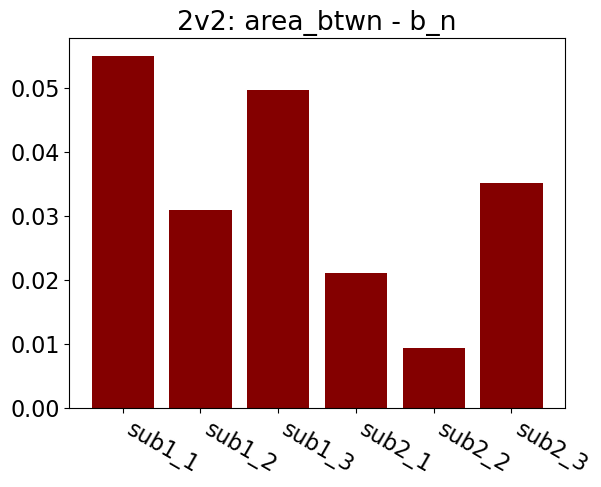

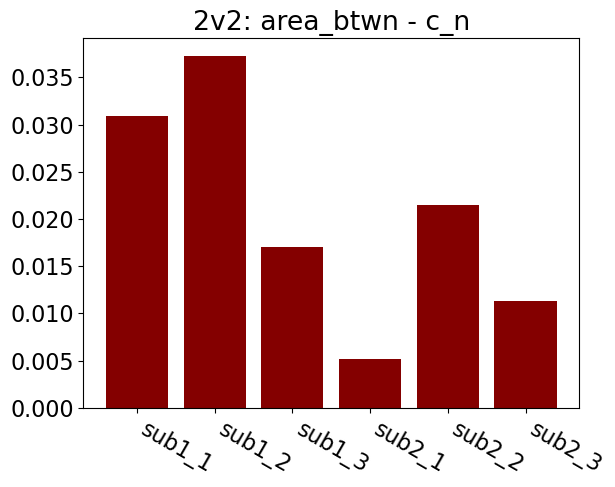

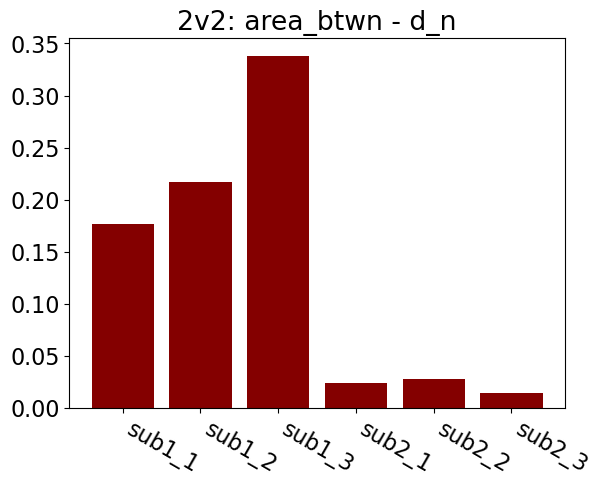

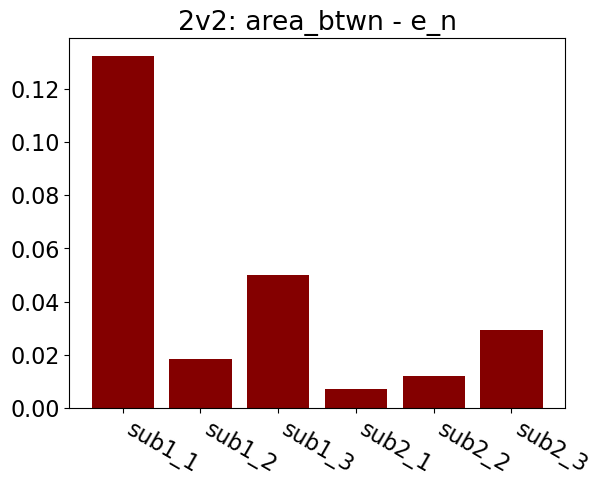

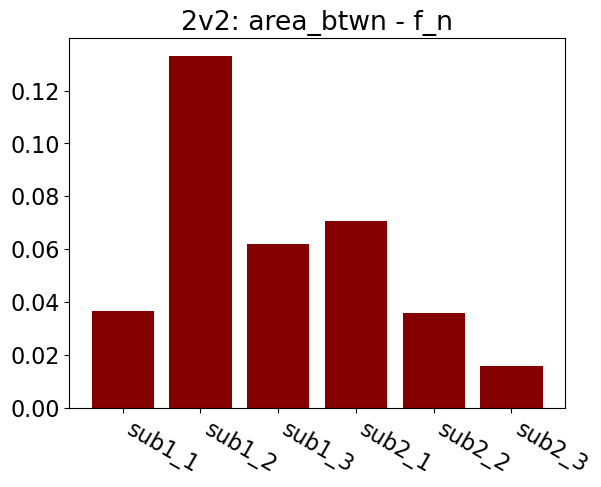

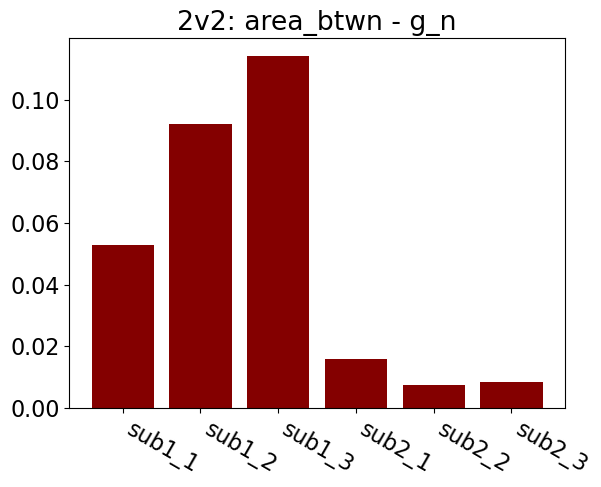

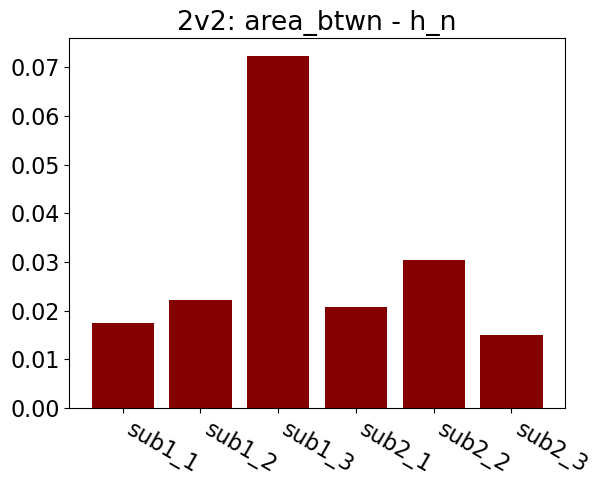

In [6]:
plt_metric_and_directions(:area_btwn, "xkcd:dark red")

### Max error


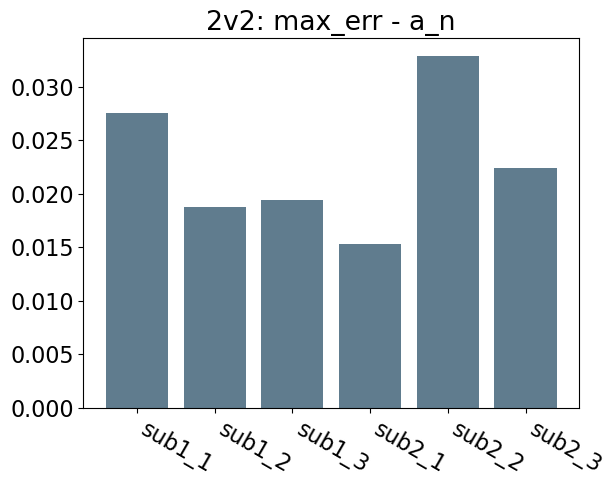

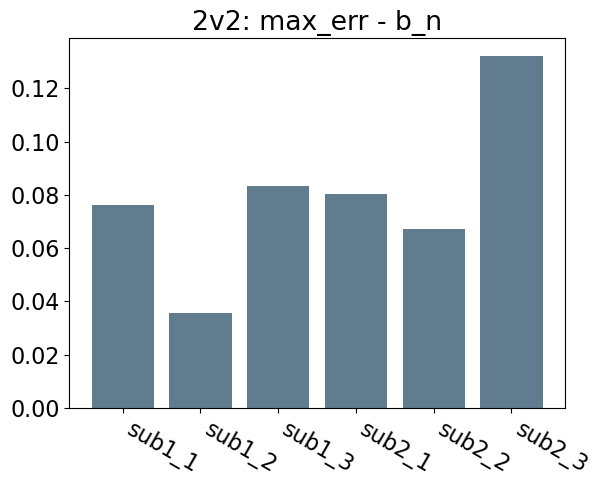

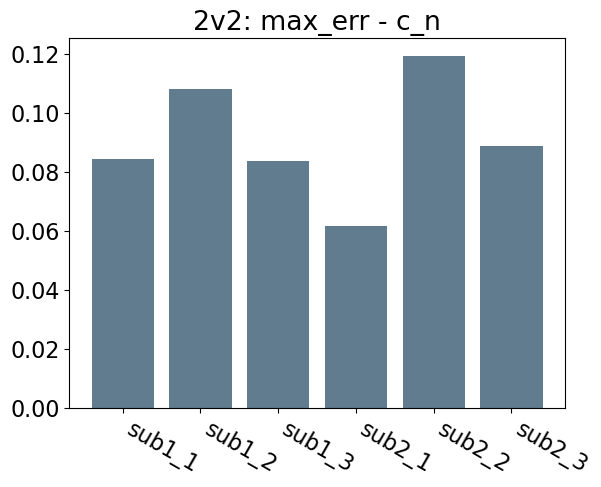

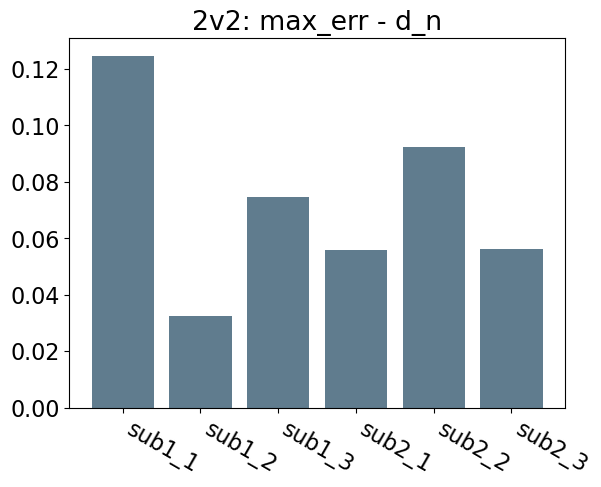

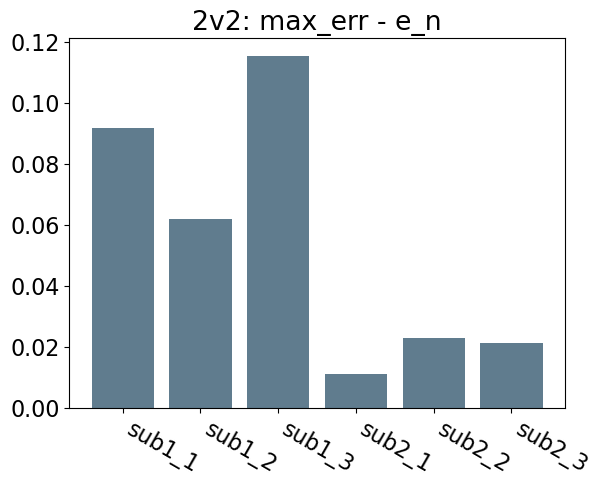

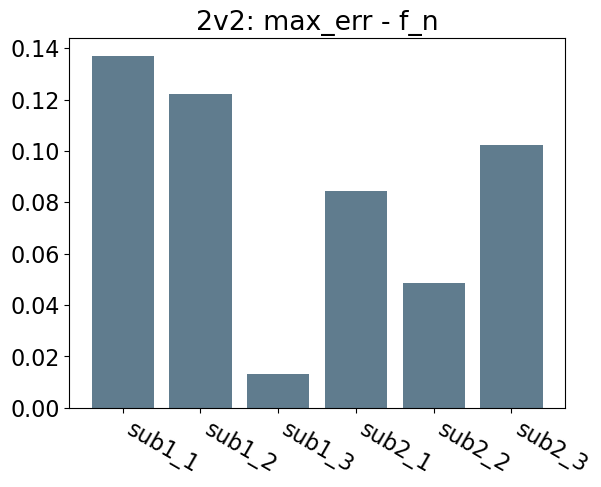

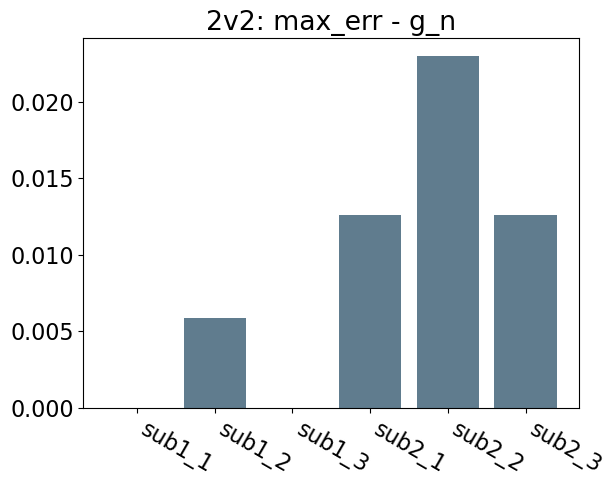

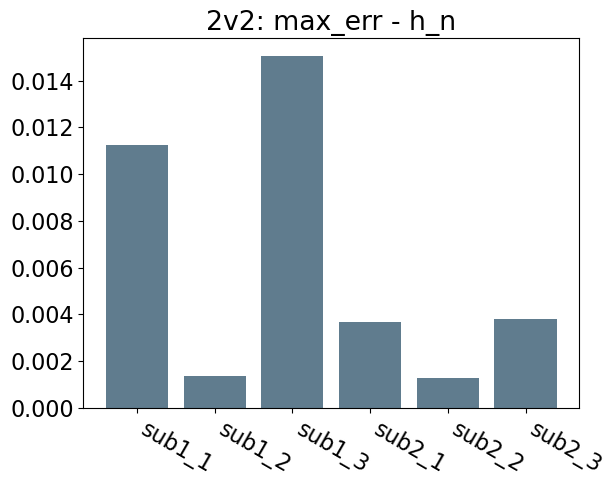

In [7]:
plt_metric_and_directions(:max_err, "xkcd:blue grey")

### Movement Efficiency

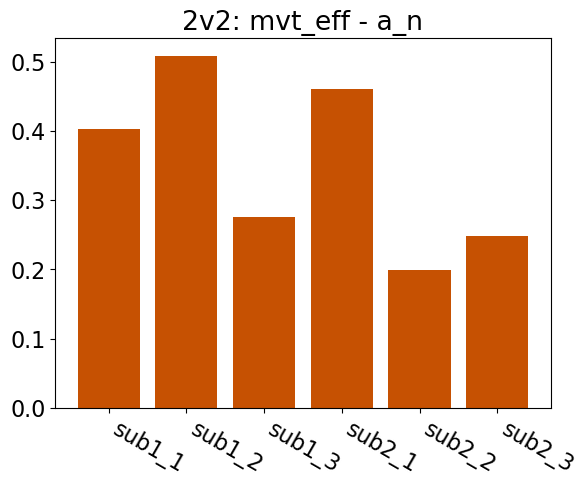

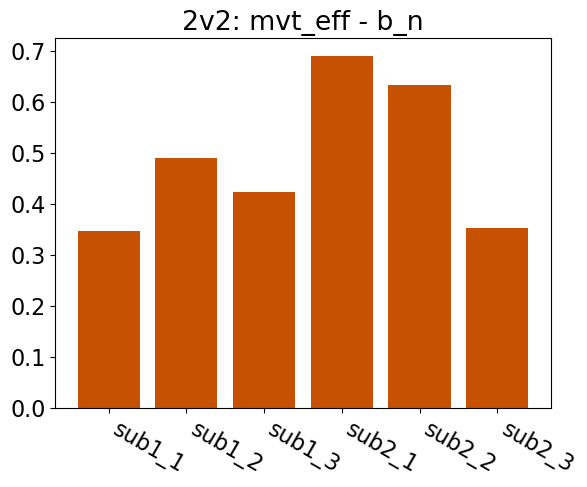

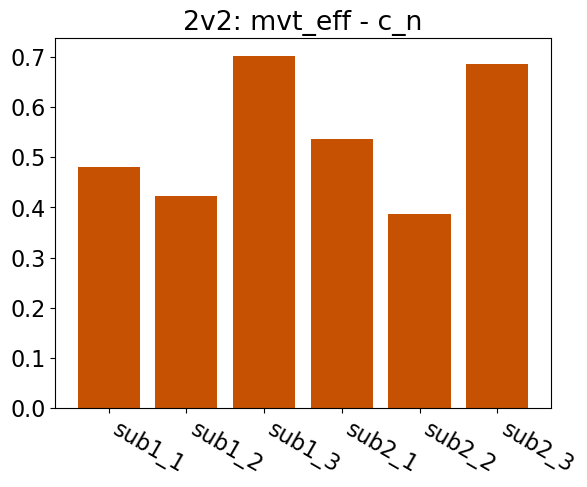

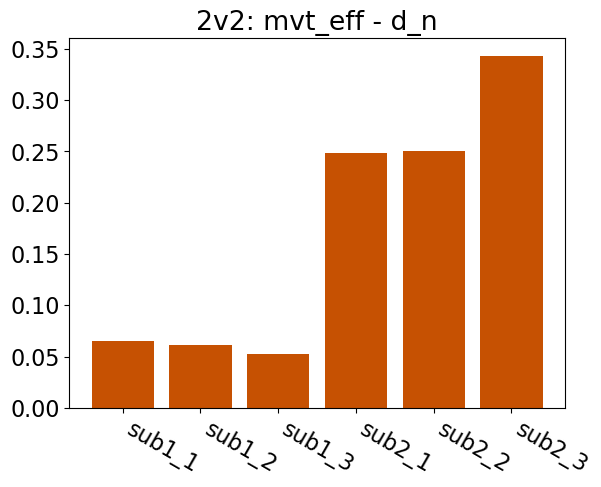

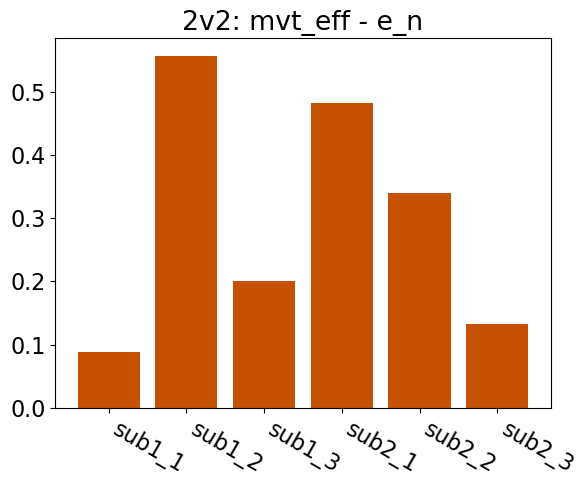

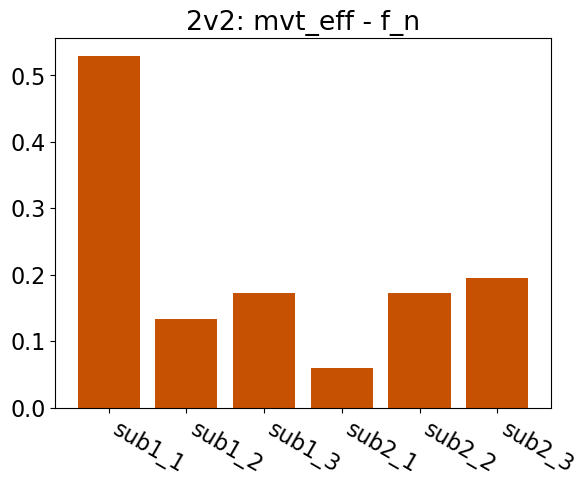

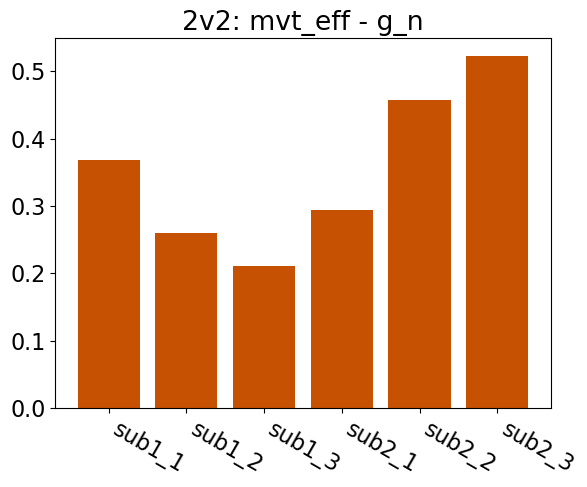

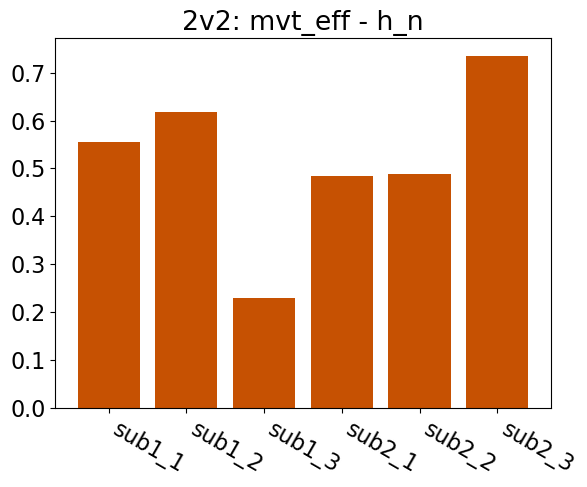

In [8]:
plt_metric_and_directions(:mvt_eff, "xkcd:dark orange")

### Max Area Region

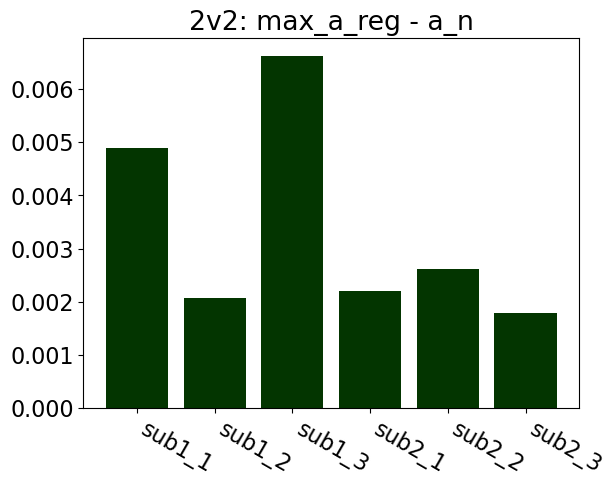

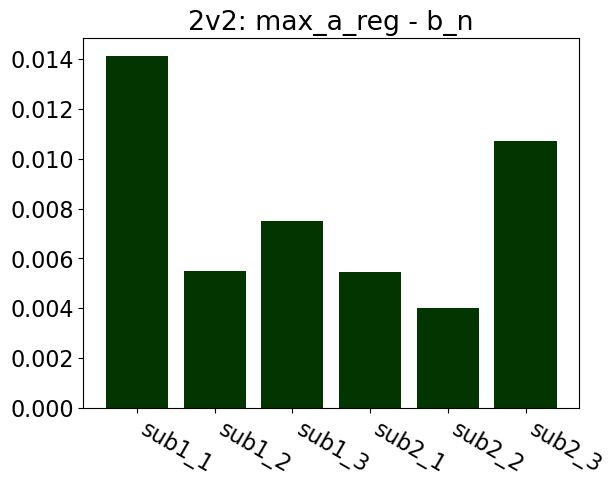

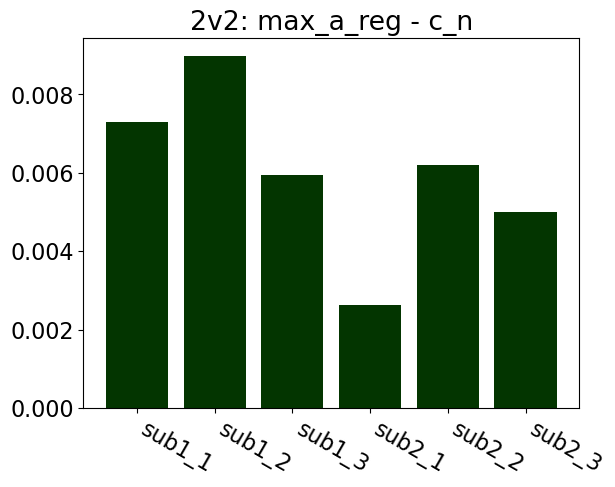

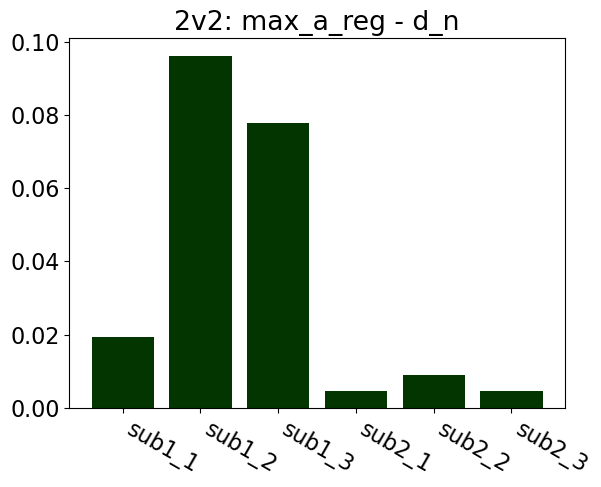

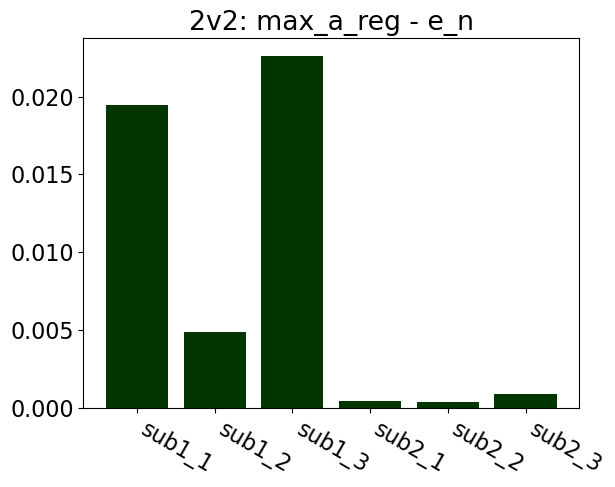

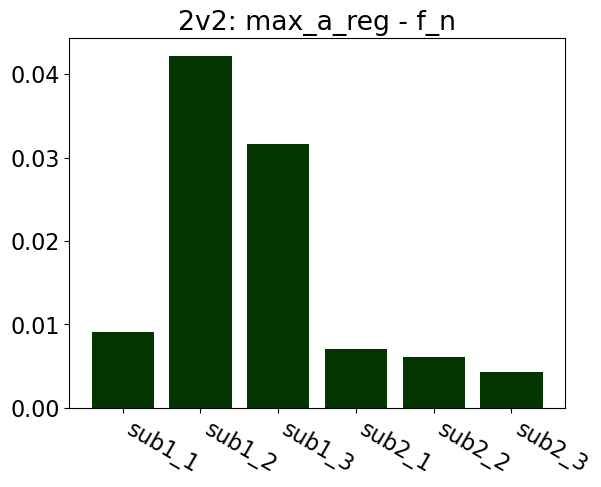

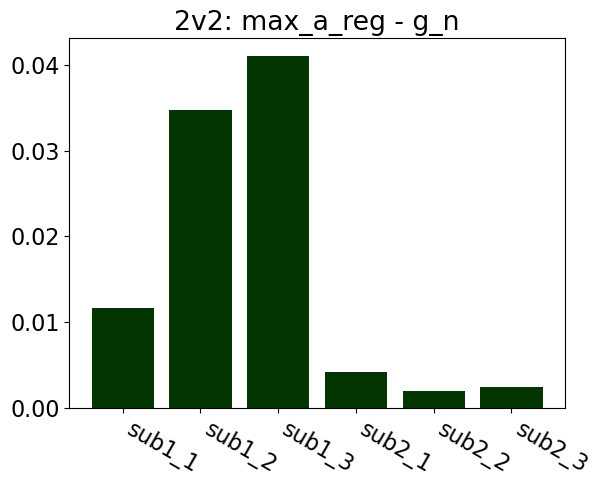

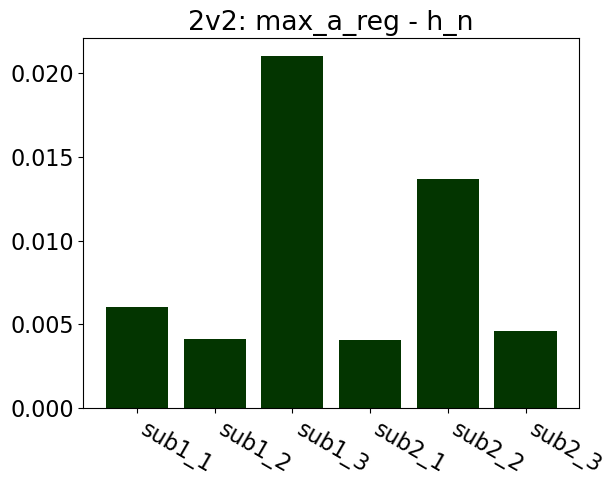

In [9]:
plt_metric_and_directions(:max_a_reg, "xkcd:dark green")

### Max Area Region Location

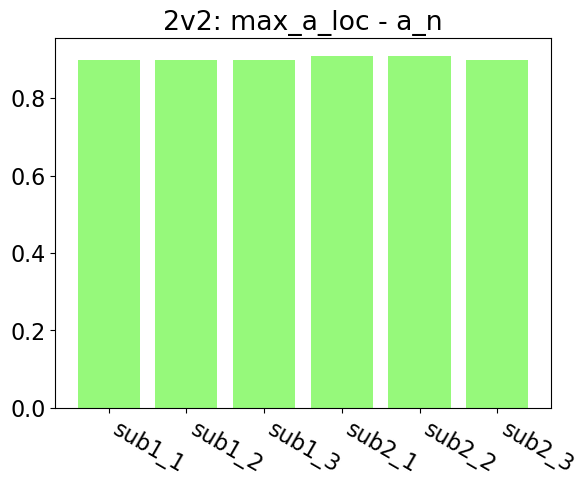

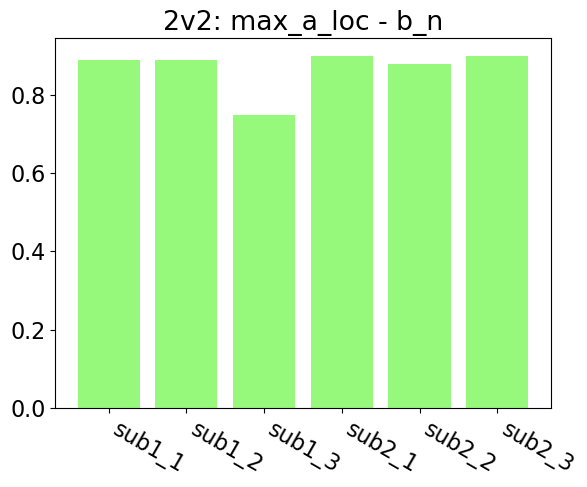

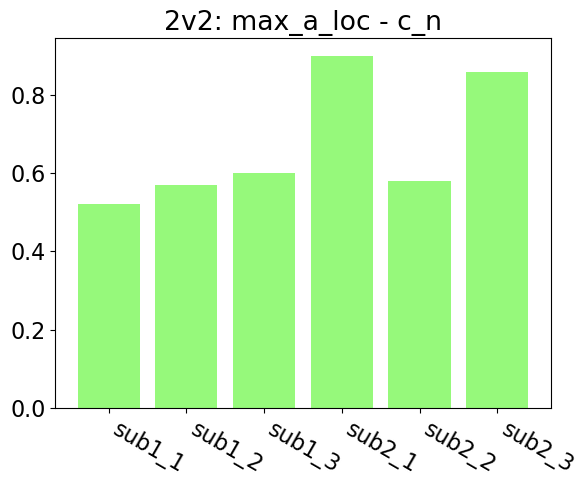

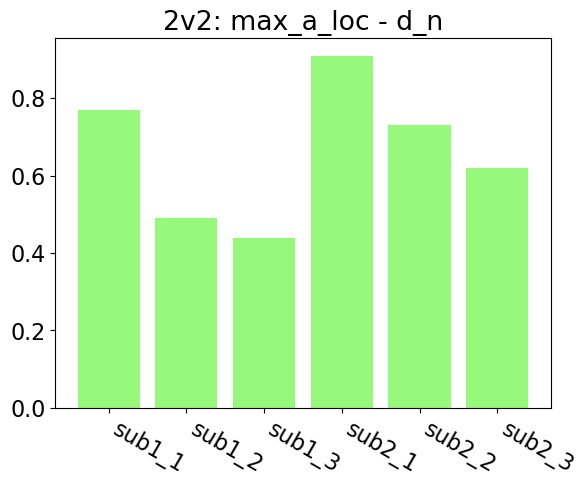

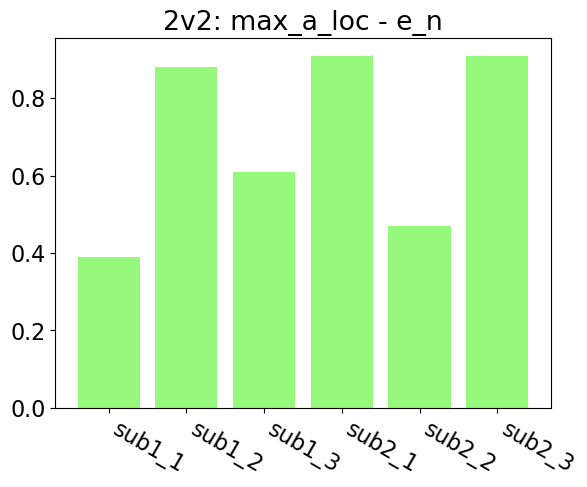

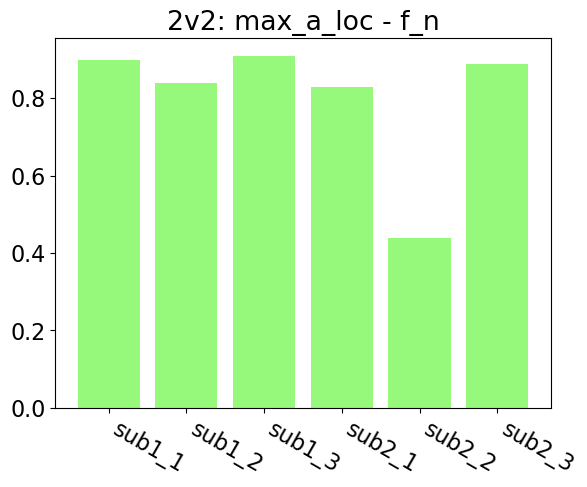

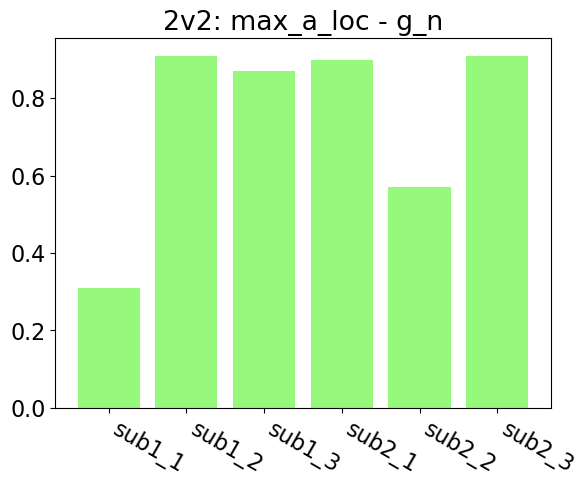

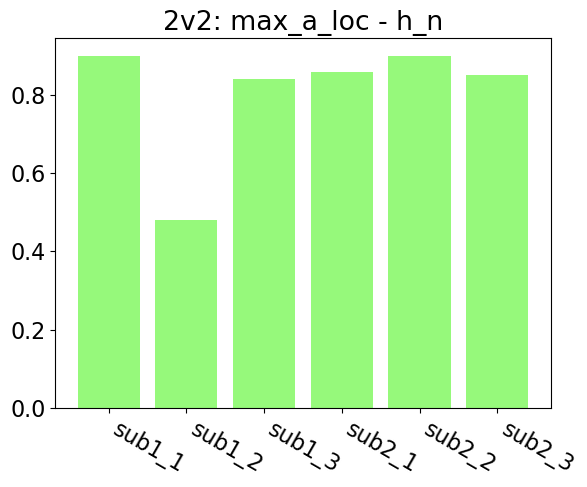

In [10]:
plt_metric_and_directions(:max_a_loc, "xkcd:light green")

### Translational Frechet Distance

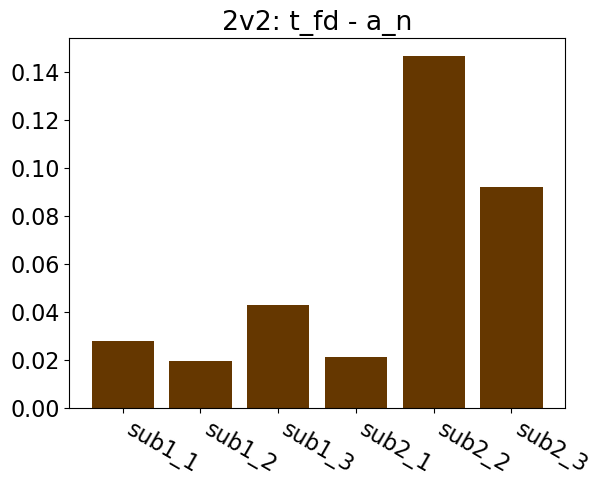

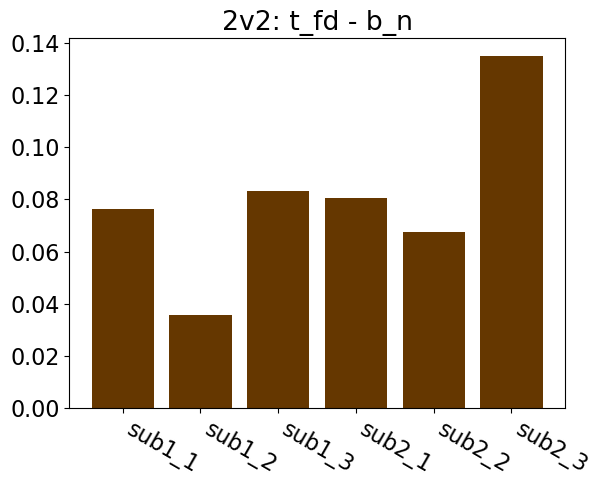

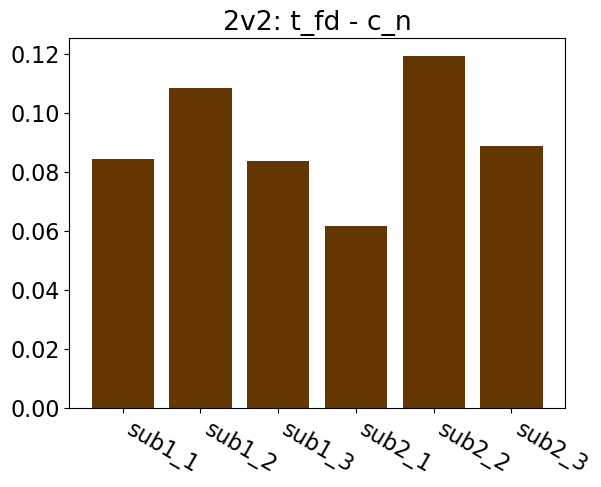

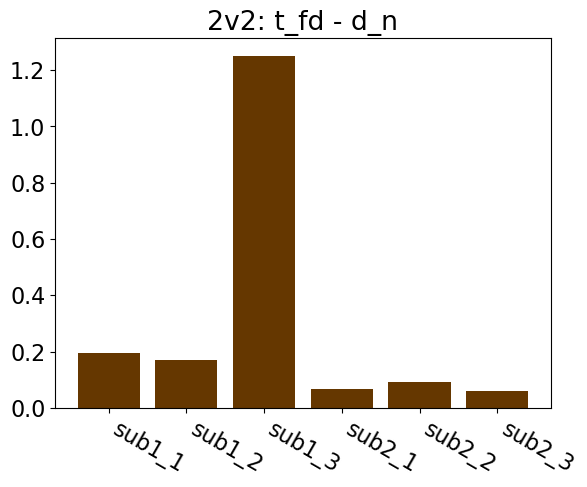

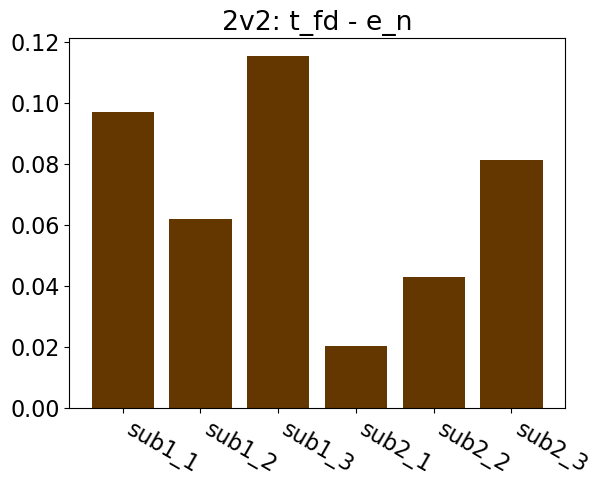

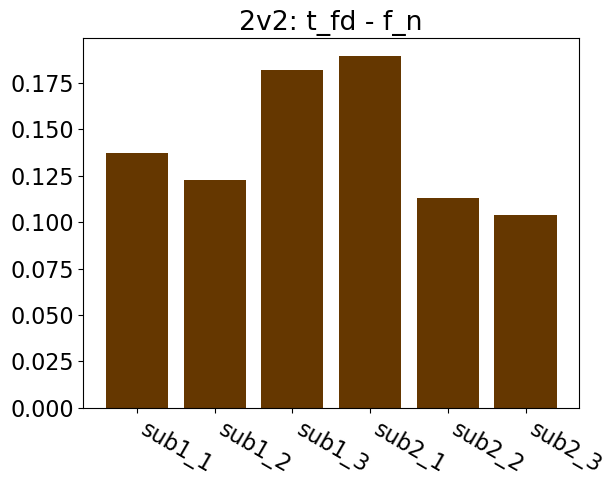

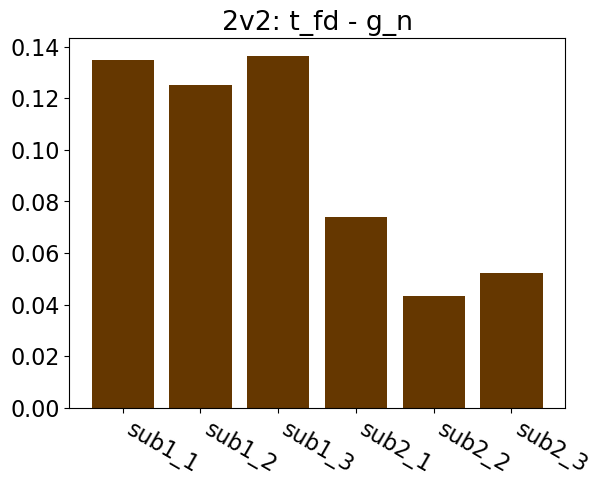

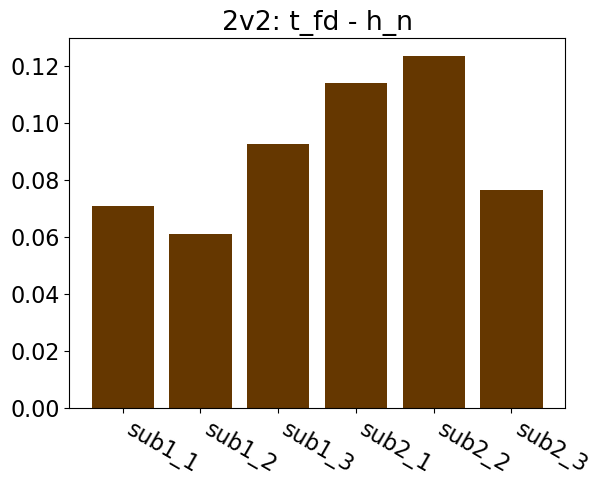

In [11]:
plt_metric_and_directions(:t_fd, "xkcd:brown")

### Rotational Frechet Distance

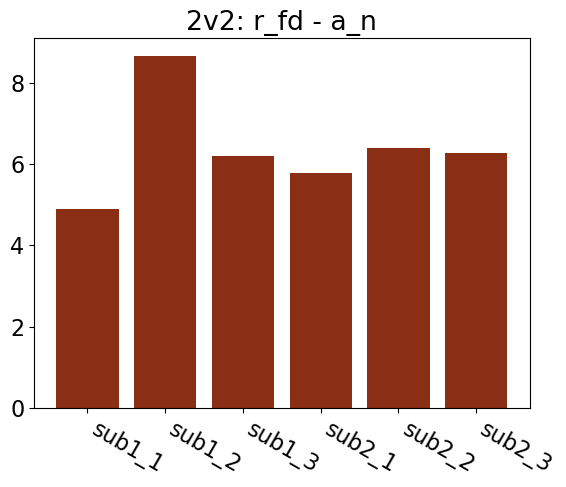

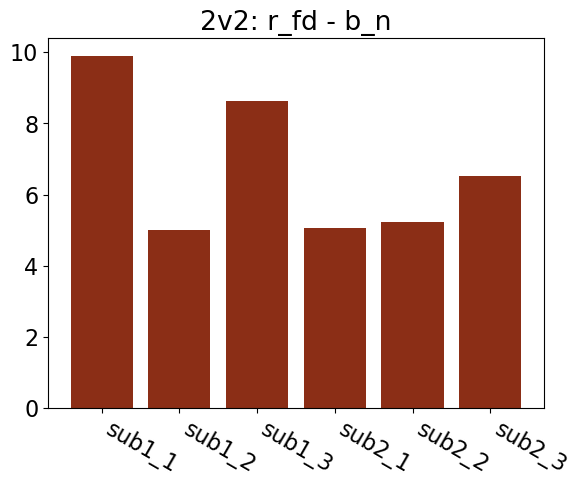

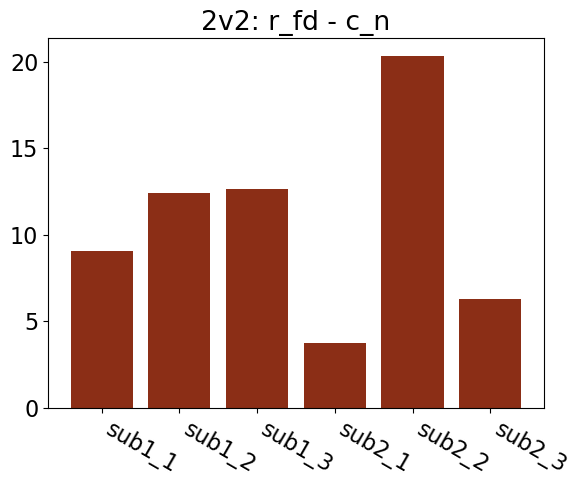

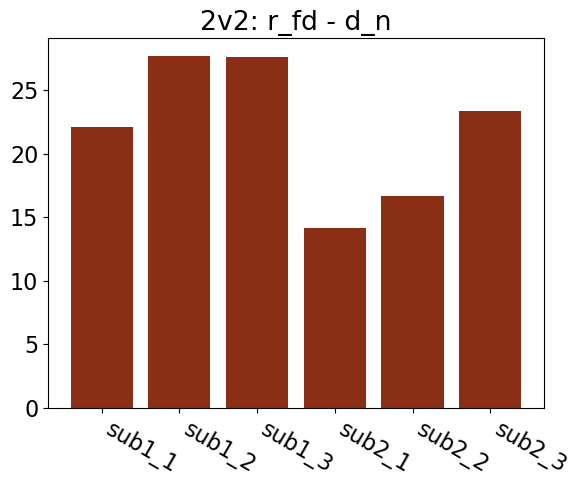

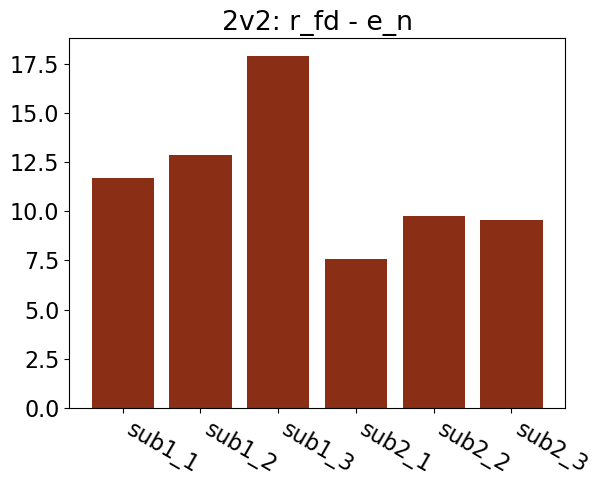

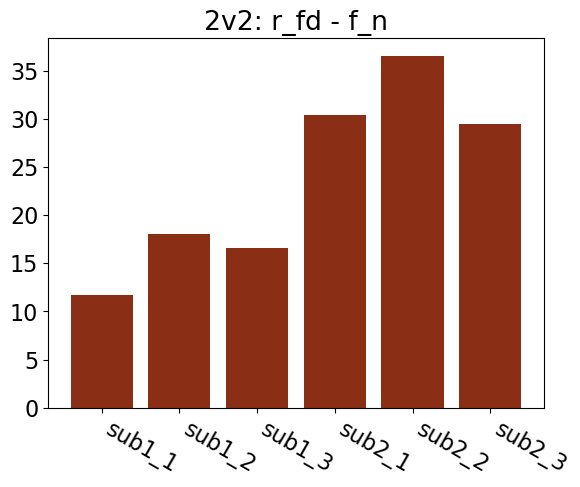

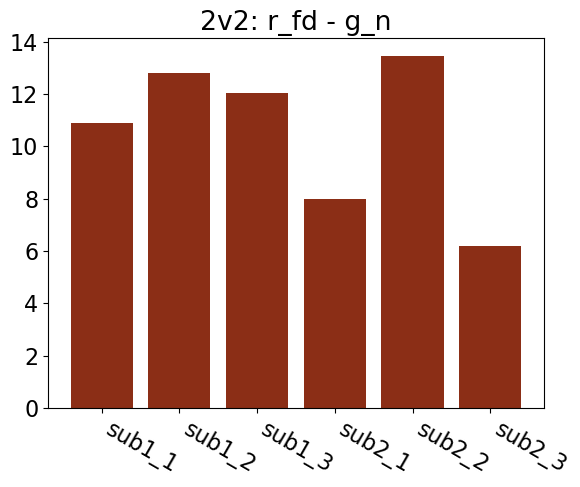

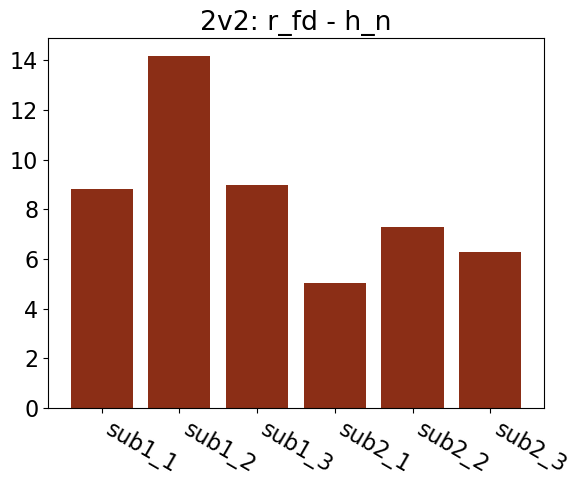

In [12]:
plt_metric_and_directions(:r_fd, "xkcd:red brown")

## Observations
Here is what I see based on the above plots.

-----

# Average Line Calculations

#### Dir: A
![Avg Asterisk](./pics/avgdebug_2v2_2subs_a_n.jpg)

#### Dir: B
![Avg Asterisk](./pics/avgdebug_2v2_2subs_b_n.jpg)

#### Dir: C
![Avg Asterisk](./pics/avgdebug_2v2_2subs_c_n.jpg)

#### Dir: D
![Avg Asterisk](./pics/avgdebug_2v2_2subs_d_n.jpg)

#### Dir: E
![Avg Asterisk](./pics/avgdebug_2v2_2subs_e_n.jpg)

#### Dir: F
![Avg Asterisk](./pics/avgdebug_2v2_2subs_f_n.jpg)

#### Dir: G
![Avg Asterisk](./pics/avgdebug_2v2_2subs_g_n.jpg)

#### Dir: H
![Avg Asterisk](./pics/avgdebug_2v2_2subs_h_n.jpg)


----

# T Tests